# Import packages

In [1]:
import scanpy as sc
import os
import pandas as pd
import scenicplus
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pycisTopic
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')



# Load data

In [2]:
# Working directories
work_dir = '/scratch/leuven/343/vsc34319/IBP/data/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'


# scRNA-seq preprocessing using Scanpy

In [86]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format:.h5ad
adata = sc.read_mtx(os.path.join(rnaseq_dir, 'snRNA_counts.mtx')).T

In [87]:
# Read in the gene names
gene_ids = pd.read_csv(os.path.join(rnaseq_dir, 'genes.csv'), sep='\t', header=None).iloc[:, -1].values
adata.var = pd.DataFrame(index=gene_ids)

# Read in barcodes
# barcodes = pd.read_csv(os.path.join(rnaseq_dir, 'barcodes_rna.csv'), sep='\t', header=None).iloc[:, -1].values

# Read in metadata
metadata = pd.read_csv(os.path.join(rnaseq_dir, 'snRNA_metadta.csv'), sep=',') #.iloc[:, -1].values
metadata.index = metadata.iloc[:,0]
metadata = metadata.rename(columns={'Unnamed: 0': 'rna_barcode'})
adata.obs = metadata
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 61472 × 36114
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

# Basic quality control

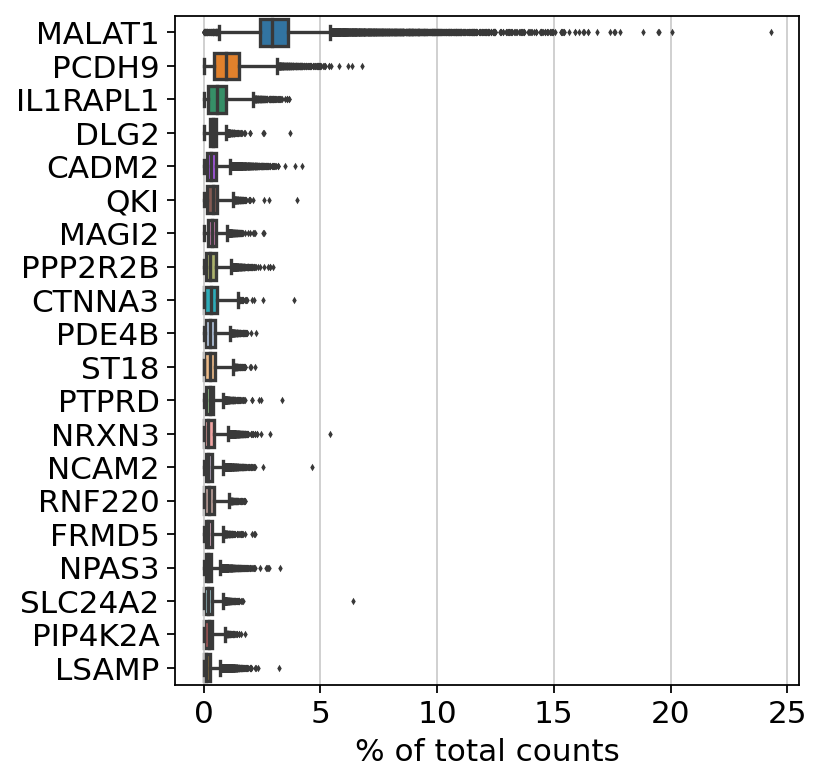

In [88]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [89]:
# Only keep cells with at least 200 genes expressed and only keep genes which are expressed in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 61472 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes'
    var: 'n_cells'

In [90]:
# Predict and filter out doublets using Scrublet
sc.external.pp.scrublet(adata) #estimates doublets

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 49.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.5%


In [91]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 61005 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet'

In [92]:
# check if mitochondrial genes are present
sum(adata.var_names.str.startswith('MT-'))

0

Comment:
    Mitochondrial genes are not present in our dataset

In [93]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 61005 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

... storing 'Sample.ID' as categorical
... storing 'Sex' as categorical
... storing 'Diagnosis' as categorical
... storing 'cluster' as categorical
... storing 'celltype' as categorical


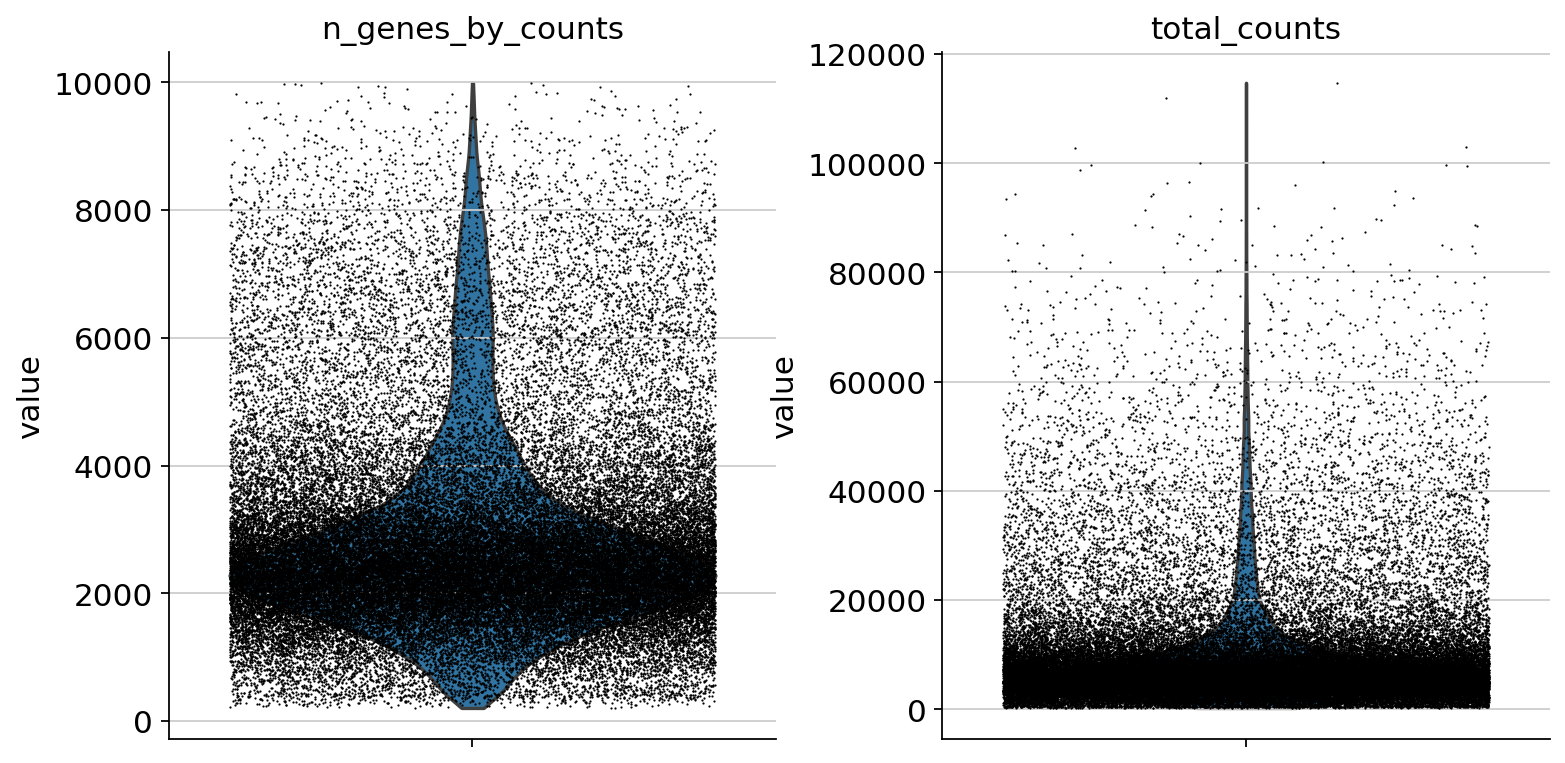

In [94]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

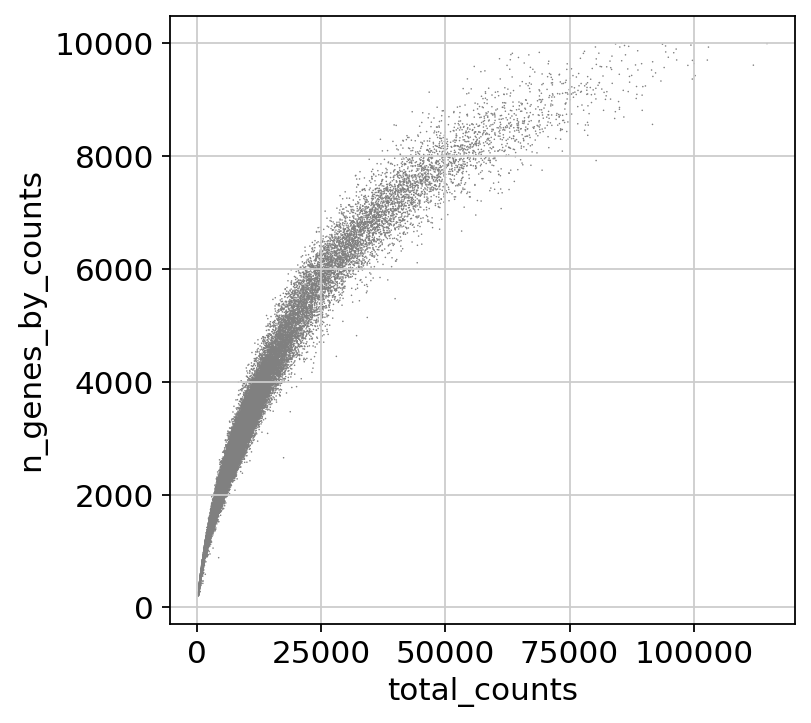

In [95]:
# Remove cells that have too many total counts
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [96]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata

View of AnnData object with n_obs × n_vars = 60139 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

# Data Normalization

In [97]:
# Total-count (library-size) correction normalize the data matrix X to 10,000 reads per cell, so that counts become comparable among cells
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

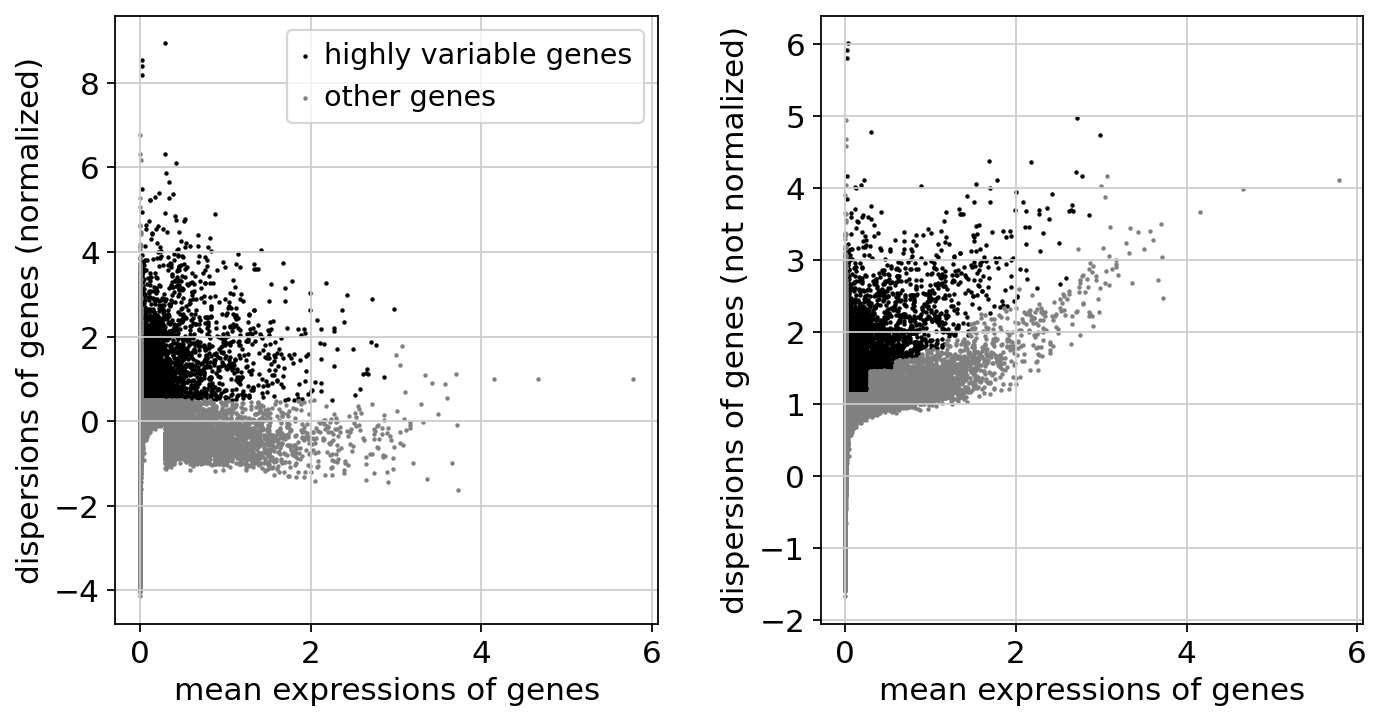

In [98]:
sc.pl.highly_variable_genes(adata)

In [ ]:
# Do the filtering.
adata = adata[:, adata.var.highly_variable]

# Regress out effects of total counts per cell and the percentage of batch genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'Batch'])

# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

adata

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
adata

In [ ]:
# A scatter plot in the PCA coordinates
sc.pl.pca(adata, color=['GFAP', 'CELF2'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations.

In [ ]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['PALM2', 'LRMDA'], palette="Set2", color_map=mpl.cm.Reds)

In [ ]:
sc.pl.umap(adata, color=['GFAP', 'SLC17A7', 'GAD2', 'CSF1R', 'MBP', 'PDGFRA'], palette="Set2", color_map=mpl.cm.Reds)

# Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
# Plot the clusters, which agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['leiden', 'PALM2', 'LRMDA'])

In [ ]:
sc.pl.umap(adata, color=['leiden', 'GFAP', 'SLC17A7', 'GAD2', 'CSF1R', 'MBP', 'PDGFRA'])

In [ ]:
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden_res_0.5')
sc.pl.umap(adata, color = 'leiden_res_0.5')

In [ ]:
sc.tl.leiden(adata, resolution = 0.2, key_added = 'leiden_res_0.2')
sc.pl.umap(adata, color = 'leiden_res_0.2')

In [ ]:
sc.tl.leiden(adata, resolution = 0.1, key_added = 'leiden_res_0.1')
sc.pl.umap(adata, color = 'leiden_res_0.1')

In [ ]:
sc.tl.leiden(adata, resolution = 0.01, key_added = 'leiden_res_0.01')
sc.pl.umap(adata, color = 'leiden_res_0.01')

# Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.01', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.01', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.01', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Cell type annotation from the Nature paper

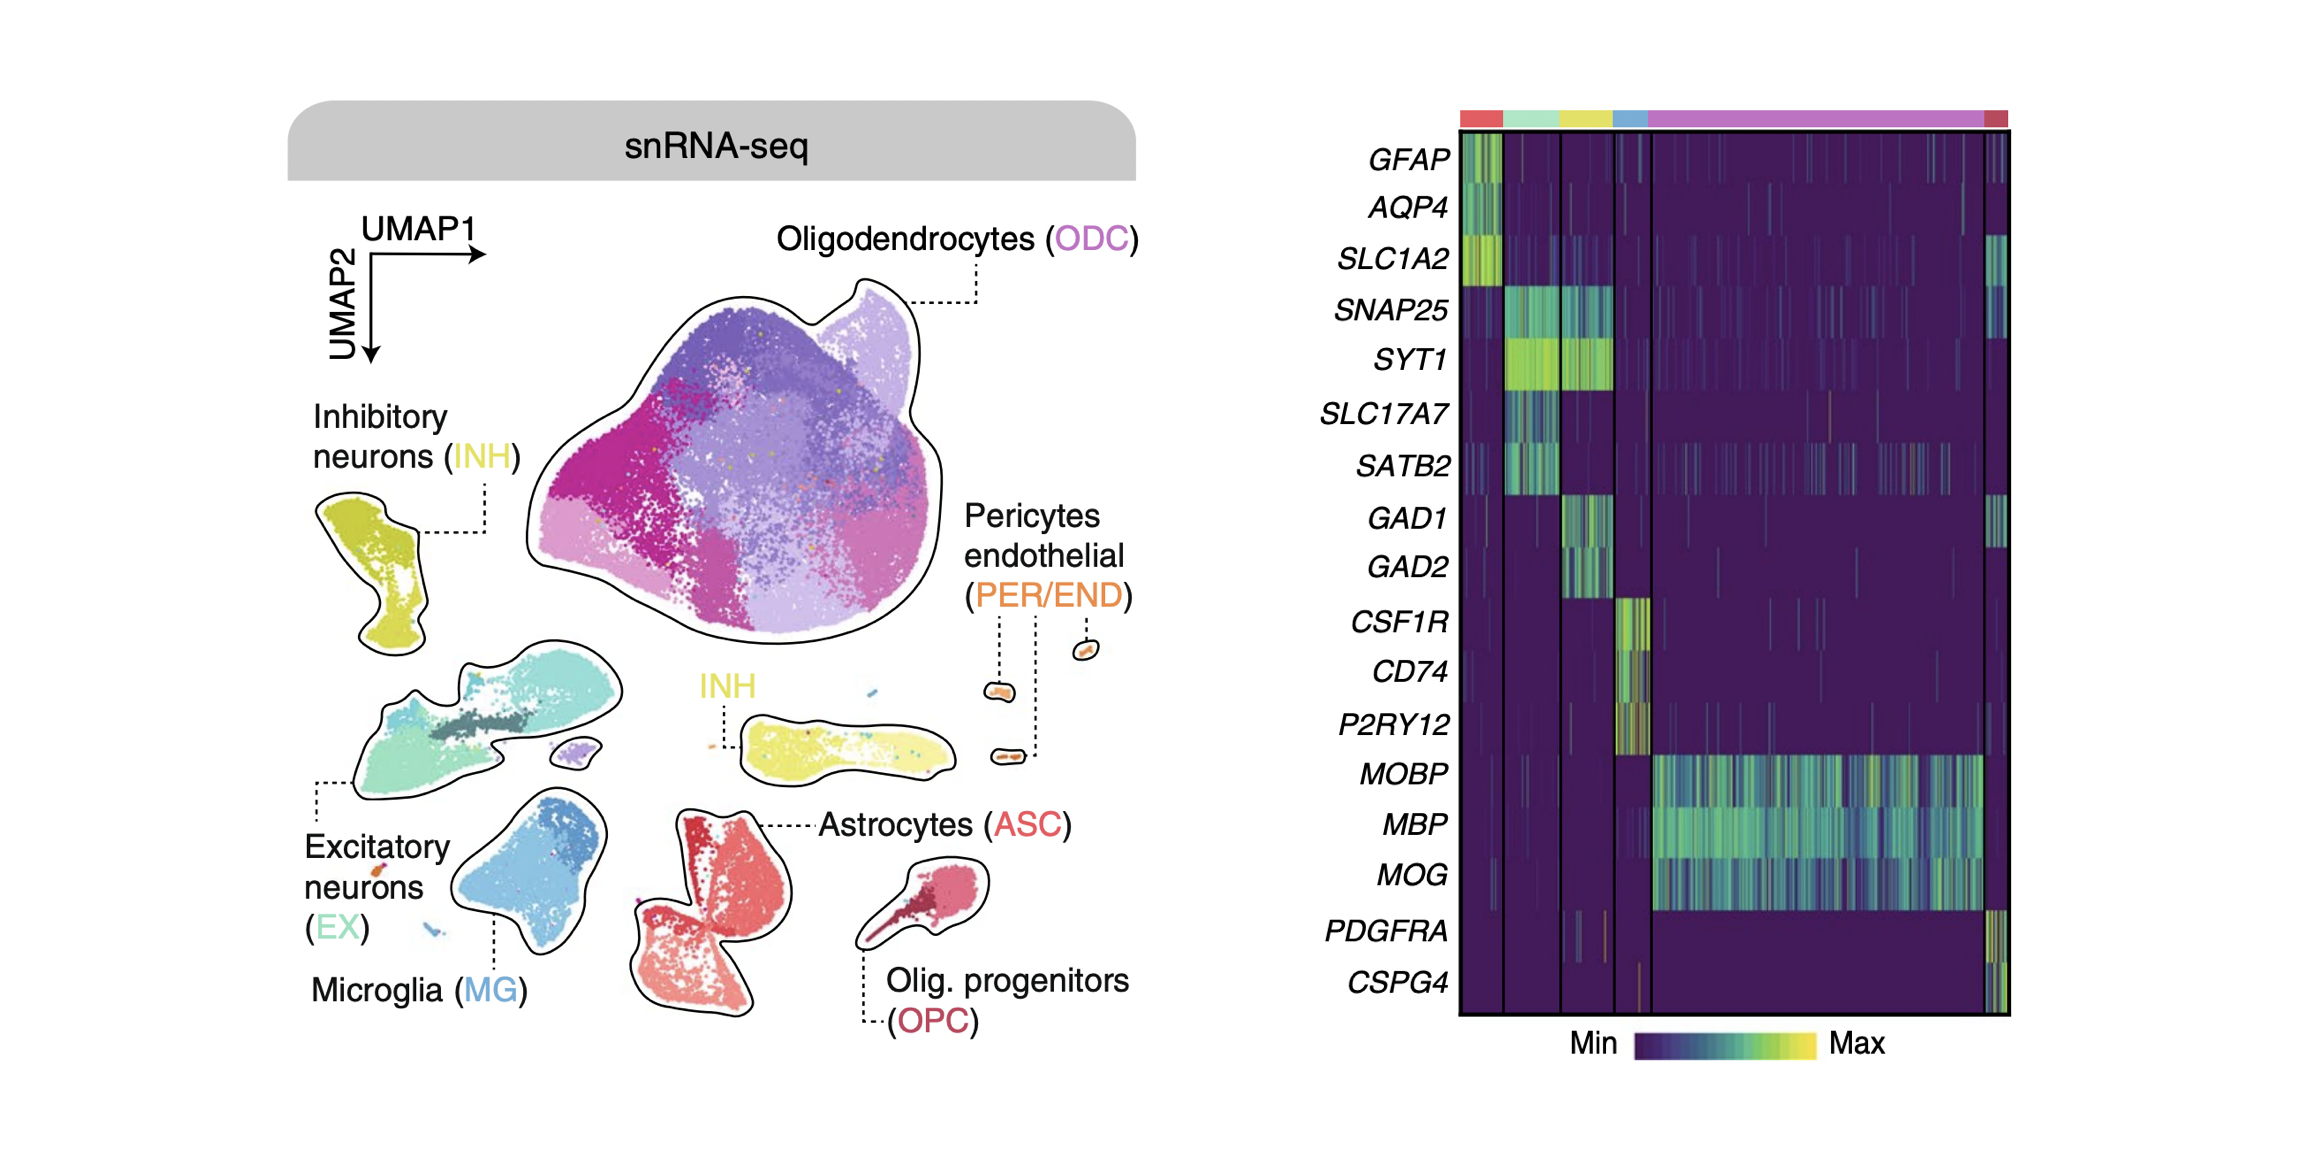

# Manual cell type annotation

In [ ]:
# Marker genes from supplementary information
EX1 = ['LAMP5', 'LINC00507']
EX2 = ['RORB']
EX3 = ['RORB', 'THEMIS']
EX4 = ['FEZF2']
EX5 = ['NRGN']
INH1 = ['VIP']
INH2 = ['PVALB']
INH3 = ['SST']
INH4 = ['LAMP5']
excinh_genes = list(set(EX1 + EX2 + EX3 + EX4 + EX5 + INH1 + INH2 + INH3 + INH4))
astrocyte_genes = ['GFAP', 'WIF1', 'ADAMTS17', 'TNC', 'CHI3L1', 'CHI3L2']
microglial_genes = ['SPP1', 'CD163', 'CX3CR1', 'ETS1']
oligodendrocyte_genes = ['ITPR2', 'OPALIN', 'CNP', 'CD47']

In [ ]:
sc.pl.umap(adata, color=excinh_genes, palette="Set2", color_map=mpl.cm.Reds)

In [ ]:
sc.pl.umap(adata, color=astrocyte_genes, palette="Set2", color_map=mpl.cm.Reds)

In [ ]:
sc.pl.umap(adata, color=oligodendrocyte_genes, palette="Set2", color_map=mpl.cm.Reds)

In [ ]:
sc.pl.umap(adata, color=microglial_genes, palette="Set2", color_map=mpl.cm.Reds)

`
ODC: Oligodendrocytes
EXC: Excitatory Neurons
INH: Inhibitory Neurons
ASC: Astrocytes
MG: Microglia
OPC: Oligodendrocytes Progenitors
`

In [ ]:
other_markers=['GFAP','AQP4','SLC1A2','SNAP25','SYT1','SLC17A7','SATB2',
               'GAD1','GAD2','CSF1R','CD74','P2RY12','MOBP','MBP','MOG','PDGFRA',
               'CSPG4']
sc.pl.umap(adata, color=other_markers, palette="Set2", color_map=mpl.cm.Reds)

In [ ]:
sc.pl.umap(adata, color = 'leiden_res_0.01', legend_loc='on data')

In [ ]:
annotations = ['ODC', 'INH', 'EX', 'ASC', 'MG', 'OPC', 'PER_END', 'INH2']
adata.rename_categories('leiden_res_0.01', annotations)
sc.pl.umap(adata, color = 'leiden_res_0.01', legend_loc='on data')

In [ ]:
annotations = ['ODC', 'EXC1', 'ASC', 'MG', 'INH1', 'OPC', 'INH2', 'ODC2', 'EXC2', 'INH3', 'PER.END', 'MG2']
adata.rename_categories('leiden_res_0.1', annotations)
sc.pl.umap(adata, color = 'leiden_res_0.1', legend_loc='on data')

# Cell type annotation via metadata

In [ ]:
sc.pl.umap(adata, color='celltype')

In [ ]:
# visualize the marker genes
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

# Saving the data

In [ ]:
adata.raw.to_adata().write(os.path.join(state_dir, 'alzheimers.raw.h5ad'))
adata.write(os.path.join(state_dir, 'alzheimers.h5ad'), compression='gzip') 

# Loading data

In [3]:
adata = sc.read_h5ad(os.path.join(state_dir, 'alzheimers.h5ad'))
adata.obs.head()

rna_barcode  Sample.ID  Batch Sex  Age Diagnosis  \
Unnamed: 0                                                                    
AAACCCAAGAAGCTCG-1  AAACCCAAGAAGCTCG-1  Sample-19      3   F   90        AD   
AAACCCAAGGATGCGT-1  AAACCCAAGGATGCGT-1  Sample-19      3   F   90        AD   
AAACGAAGTTCGAAGG-1  AAACGAAGTTCGAAGG-1  Sample-19      3   F   90        AD   
AAAGAACGTATTCCGA-1  AAAGAACGTATTCCGA-1  Sample-19      3   F   90        AD   
AAAGGATAGGCCTAAG-1  AAAGGATAGGCCTAAG-1  Sample-19      3   F   90        AD   

                      UMAP_1     UMAP_2 cluster celltype  n_genes  \
Unnamed: 0                                                          
AAACCCAAGAAGCTCG-1 -0.439007   8.746606    ODC9      ODC     2057   
AAACCCAAGGATGCGT-1  5.148611  11.073421    ODC7      ODC     3034   
AAACGAAGTTCGAAGG-1 -0.249035   6.647623    ODC1      ODC     1419   
AAAGAACGTATTCCGA-1 -1.294634   8.344845    ODC2      ODC     1334   
AAAGGATAGGCCTAAG-1 -0.349851  10.167821    ODC9      ODC     1528   

                    doublet_score  predicted_doublet  n_genes_by_counts  \
Unnamed: 0                                                                
AAACCCAAGAAGCTCG-1       0.029979              False               2057   
AAACCCAAGGATGCGT-1       0.022619              False               3034   
AAACGAAGTTCGAAGG-1       0.093534              False               1419   
AAAGAACGTATTCCGA-1       0.047601              False               1334   
AAAGGATAGGCCTAAG-1       0.007336              False               1528   

                    total_counts leiden leiden_res_0.5 leiden_res_0.2  \
Unnamed: 0                                                              
AAACCCAAGAAGCTCG-1        4893.0      6              4              2   
AAACCCAAGGATGCGT-1        8986.0      8              7              2   
AAACGAAGTTCGAAGG-1        2561.0      1              1              0   
AAAGAACGTATTCCGA-1        2398.0      6              1              2   
AAAGGATAGGCCTAAG-1        3330.0      6              4              2   

                   leiden_res_0.1 leiden_res_0.01  
Unnamed: 0                                         
AAACCCAAGAAGCTCG-1            ODC             ODC  
AAACCCAAGGATGCGT-1            ODC             ODC  
AAACGAAGTTCGAAGG-1            ODC             ODC  
AAAGAACGTATTCCGA-1            ODC             ODC  
AAAGGATAGGCCTAAG-1            ODC             ODC

# ATAC-seq data

In [4]:
import os
import pycisTopic
import scanpy as sc
import pyranges as pr
import requests
import pandas as pd
import pickle
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.pseudobulk_peak_calling import peak_calling
from pycisTopic.iterative_peak_calling import *
%matplotlib inline

In [5]:
# Make a directory for to store the processed scRNA-seq data.
atac_metadata = pd.read_csv(os.path.join(atacseq_dir, 'snATAC_metadta.csv'), sep=',') #.iloc[:, -1].values
atac_metadata.index = atac_metadata.iloc[:,0]
atac_metadata = atac_metadata.rename(columns={'Unnamed: 0': 'barcode'})
atac_metadata['sample_id'] = 'alzheimers'
atac_metadata['celltype'] = atac_metadata['celltype'].astype(str)
pickle.dump(atac_metadata, open(os.path.join(state_dir, 'atac_metadata.pkl'), 'wb'))
atac_metadata

barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACGAAAGAAACGCC-13  AAACGAAAGAAACGCC-13   Sample-96      1   M   79   
AAACGAAAGAAATGGG-11  AAACGAAAGAAATGGG-11  Sample-101      2   F   74   
AAACGAAAGAAATGGG-5    AAACGAAAGAAATGGG-5   Sample-37      3   F   87   
AAACGAAAGAAATTCG-13  AAACGAAAGAAATTCG-13   Sample-96      1   M   79   
AAACGAAAGAACGACC-8    AAACGAAAGAACGACC-8   Sample-43      1   F   90   
...                                  ...         ...    ...  ..  ...   
TTTGTGTTCTTCATAC-13  TTTGTGTTCTTCATAC-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-13  TTTGTGTTCTTCCACG-13   Sample-96      1   M   79   
TTTGTGTTCTTCCACG-7    TTTGTGTTCTTCCACG-7   Sample-46      2   M   90   
TTTGTGTTCTTGCGCT-1    TTTGTGTTCTTGCGCT-1   Sample-82      2   M   79   
TTTGTGTTCTTGCGCT-9    TTTGTGTTCTTGCGCT-9   Sample-47      3   M   90   

                    Diagnosis    UMAP_1    UMAP_2    cluster celltype  \
Unnamed: 0                                                              
AAACGAAAGAAACGCC-13   Control  4.653650 -2.973710      ODC.f      ODC   
AAACGAAAGAAATGGG-11   Control  6.781233 -2.420259      ODC.k      ODC   
AAACGAAAGAAATGGG-5         AD -2.631755 -6.038205  PER.END.a  PER.END   
AAACGAAAGAAATTCG-13   Control -7.145253  2.478923       EX.b       EX   
AAACGAAAGAACGACC-8         AD  3.383448  0.103595      ODC.a      ODC   
...                       ...       ...       ...        ...      ...   
TTTGTGTTCTTCATAC-13   Control  6.218156 -2.558979      ODC.j      ODC   
TTTGTGTTCTTCCACG-13   Control  4.888400 -5.111481      ODC.e      ODC   
TTTGTGTTCTTCCACG-7         AD  6.508900  0.919111      ODC.b      ODC   
TTTGTGTTCTTGCGCT-1    Control  5.296374 -4.003198      ODC.h      ODC   
TTTGTGTTCTTGCGCT-9         AD -7.266353 -9.165766       MG.a       MG   

                      sample_id  
Unnamed: 0                       
AAACGAAAGAAACGCC-13  alzheimers  
AAACGAAAGAAATGGG-11  alzheimers  
AAACGAAAGAAATGGG-5   alzheimers  
AAACGAAAGAAATTCG-13  alzheimers  
AAACGAAAGAACGACC-8   alzheimers  
...                         ...  
TTTGTGTTCTTCATAC-13  alzheimers  
TTTGTGTTCTTCCACG-13  alzheimers  
TTTGTGTTCTTCCACG-7   alzheimers  
TTTGTGTTCTTGCGCT-1   alzheimers  
TTTGTGTTCTTGCGCT-9   alzheimers  

[132623 rows x 11 columns]

In [6]:
# Specify the location of the ATAC fragments file, this is the main input into pycisTopic.
fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}

# Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set

In [7]:
# Get chromosome sizes (for hg38 here)
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [ ]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = atac_metadata,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(state_dir, 'consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(state_dir, 'consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 4,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/tmp/rayspill',
                 split_pattern = '-')

2022-11-12 02:08:05,680 cisTopic     INFO     Reading fragments from /scratch/leuven/343/vsc34319/IBP/data/ibp-2022-data/sn_atac_seq/fragments.tsv.gz


2022-11-12 02:26:55,761	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(export_pseudobulk_ray pid=1473320) 2022-11-12 02:27:08,287 cisTopic     INFO     Creating pseudobulk for ASC
(export_pseudobulk_ray pid=1473321) 2022-11-12 02:27:14,950 cisTopic     INFO     Creating pseudobulk for EX
(export_pseudobulk_ray pid=1473319) 2022-11-12 02:27:18,117 cisTopic     INFO     Creating pseudobulk for INH


(raylet) Spilled 13620 MiB, 2 objects, write throughput 872 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 27241 MiB, 5 objects, write throughput 555 MiB/s.
(raylet) Spilled 40861 MiB, 8 objects, write throughput 563 MiB/s.
(raylet) Spilled 54482 MiB, 11 objects, write throughput 536 MiB/s.
(raylet) Spilled 68103 MiB, 14 objects, write throughput 517 MiB/s.


(export_pseudobulk_ray pid=1473319) 2022-11-12 02:41:58,437 cisTopic     INFO     INH done!
(export_pseudobulk_ray pid=1473319) 2022-11-12 02:41:59,330 cisTopic     INFO     Creating pseudobulk for MG


(raylet) Spilled 68103 MiB, 15 objects, write throughput 517 MiB/s.


(export_pseudobulk_ray pid=1473319) 2022-11-12 03:01:18,340 cisTopic     INFO     MG done!
(export_pseudobulk_ray pid=1473319) 2022-11-12 03:01:19,297 cisTopic     INFO     Creating pseudobulk for ODC
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:13:37,594 cisTopic     INFO     ASC done!
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:13:38,575 cisTopic     INFO     Creating pseudobulk for OPC
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:20:51,927 cisTopic     INFO     OPC done!
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:20:52,918 cisTopic     INFO     Creating pseudobulk for PER_END
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:24:32,089 cisTopic     INFO     PER_END done!
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:24:32,772 cisTopic     INFO     Creating pseudobulk for Unknown
(export_pseudobulk_ray pid=1473320) 2022-11-12 03:31:38,334 cisTopic     INFO     Unknown done!
(export_pseudobulk_ray pid=1473321) 2022-11-12 03:33:28,027 cisTopic     INFO     EX 

In [77]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(atacseq_dir, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(atacseq_dir, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [22]:
import pickle
bed_paths = pickle.load(open(os.path.join(atacseq_dir, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(atacseq_dir, 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

In [78]:
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(state_dir, 'consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=4,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = '/tmp/ray_spill')

2022-10-24 17:19:20,691	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=6463) 2022-10-24 17:19:22,172 cisTopic     INFO     Calling peaks for EX with macs2 callpeak --treatment /media/hani/SSD250/ibp/snATAC-seq/consensus_peak_calling/pseudobulk_bed_files/EX.bed.gz --name EX  --outdir /media/hani/SSD250/ibp/snATAC-seq/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda --verbose 3
(macs_call_peak_ray pid=6464) 2022-10-24 17:19:22,172 cisTopic     INFO     Calling peaks for INH with macs2 callpeak --treatment /media/hani/SSD250/ibp/snATAC-seq/consensus_peak_calling/pseudobulk_bed_files/INH.bed.gz --name INH  --outdir /media/hani/SSD250/ibp/snATAC-seq/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda --verbose 3
(macs_call_peak_ray pid=6466) 2022-10-24 17:19:22,172 cisTopic     INFO     Calling peaks for MG with macs2 callpeak --treatment /media/hani/

In [79]:
narrow_peaks_dict

{'ASC': +--------------+-----------+-----------+------------------+-------+
 | Chromosome   | Start     | End       | Name             | +6    |
 | (category)   | (int32)   | (int32)   | (object)         | ...   |
 |--------------+-----------+-----------+------------------+-------|
 | chr1         | 190815    | 191873    | ASC_peak_1a      | ...   |
 | chr1         | 190815    | 191873    | ASC_peak_1b      | ...   |
 | chr1         | 632665    | 632897    | ASC_peak_2       | ...   |
 | chr1         | 778299    | 779294    | ASC_peak_3a      | ...   |
 | ...          | ...       | ...       | ...              | ...   |
 | chrY         | 56876009  | 56876203  | ASC_peak_193901  | ...   |
 | chrY         | 56877597  | 56877805  | ASC_peak_193902  | ...   |
 | chrY         | 56879880  | 56880364  | ASC_peak_193903a | ...   |
 | chrY         | 56879880  | 56880364  | ASC_peak_193903b | ...   |
 +--------------+-----------+-----------+------------------+-------+
 Unstranded PyRanges object

In [80]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(state_dir, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [81]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-10-24 17:35:43,916 cisTopic     INFO     Extending and merging peaks per class
2022-10-24 17:39:06,818 cisTopic     INFO     Normalizing peak scores
2022-10-24 17:39:07,295 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-10-24 17:41:28,142 cisTopic     INFO     Done!


In [82]:
consensus_peaks.to_bed(
    path = os.path.join(state_dir, 'consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

# ATAC-seq quality control

In [83]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'alzheimers':os.path.join(state_dir, 'consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 4,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = '/tmp/ray_spill')

if not os.path.exists(os.path.join(state_dir, 'quality_control')):
    os.makedirs(os.path.join(state_dir, 'quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(state_dir, 'quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(state_dir, 'quality_control/profile_data_dict.pkl'), 'wb'))

2022-10-24 17:44:34,931 cisTopic     INFO     n_cpu is larger than the number of samples. Setting n_cpu to the number of samples
2022-10-24 17:44:34,931 cisTopic     INFO     Reading alzheimers
2022-10-24 18:02:46,624 cisTopic     INFO     Computing barcode rank plot for alzheimers
2022-10-24 18:02:46,681 cisTopic     INFO     Counting fragments
2022-10-24 18:03:50,880 cisTopic     INFO     Marking barcodes with more than 100
2022-10-24 18:03:51,250 cisTopic     INFO     Returning plot data
2022-10-24 18:03:51,341 cisTopic     INFO     Returning valid barcodes
2022-10-24 18:04:40,664 cisTopic     INFO     Computing duplicate rate plot for alzheimers
2022-10-24 18:06:04,798 cisTopic     INFO     Return plot data
2022-10-24 18:06:05,120 cisTopic     INFO     Computing insert size distribution for alzheimers
2022-10-24 18:06:05,120 cisTopic     INFO     Counting fragments
2022-10-24 18:06:18,319 cisTopic     INFO     Returning plot data
2022-10-24 18:11:43,172 cisTopic     INFO     Comput

/home/hani/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/hani/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/hani/miniconda3/en

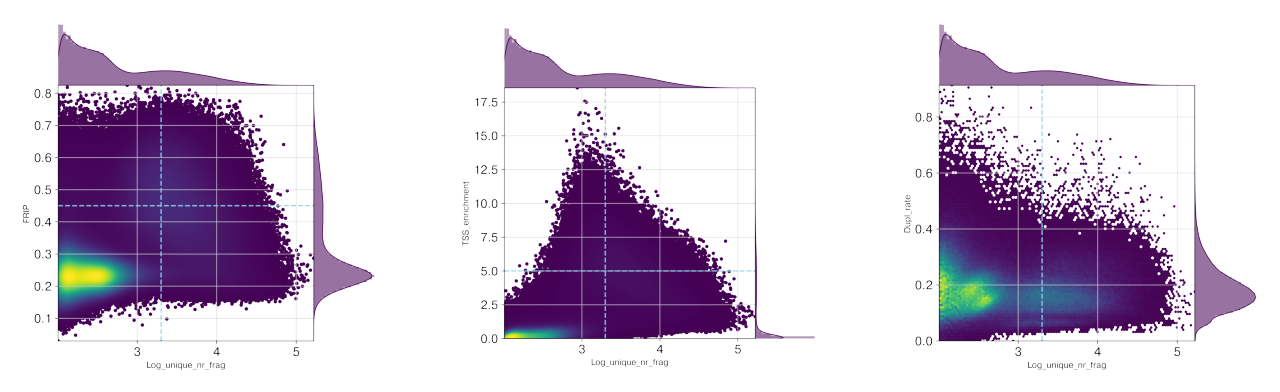

In [84]:
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['alzheimers'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [85]:
bc_passing_filters = {'alzheimers':[]}
bc_passing_filters['alzheimers'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(state_dir, 'quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['alzheimers'])} barcodes passed QC stats")

32428 barcodes passed QC stats


When we had a bad ATAC-seq 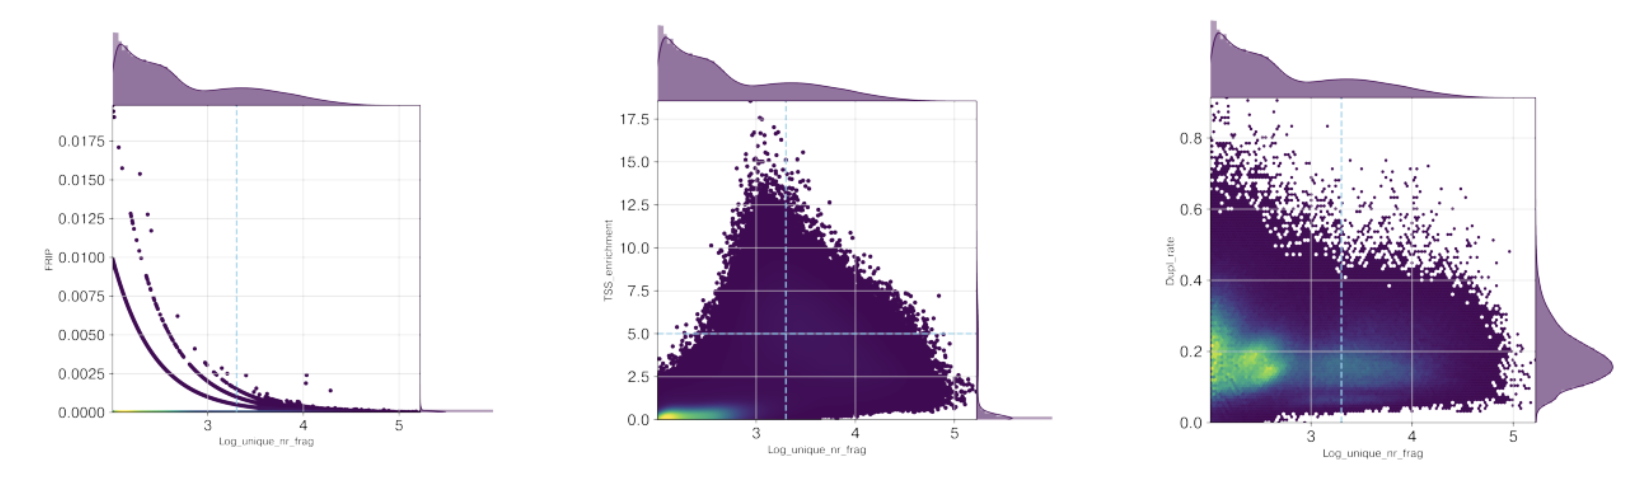

# Checkpoint load

In [2]:
# Load if needed

fragments_dict = {'alzheimers': os.path.join(atacseq_dir, 'fragments.tsv.gz')}
adata = sc.read_h5ad(os.path.join(state_dir, 'alzheimers.h5ad'))
path_to_regions = {'alzheimers':os.path.join(state_dir, 'consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= os.path.join(state_dir, 'hg38-blacklist.v2.bed')
metadata_bc = pickle.load(open(os.path.join(state_dir, 'quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(state_dir, 'quality_control/bc_passing_filters.pkl'), 'rb'))
atac_metadata = pickle.load(open(os.path.join(state_dir, 'atac_metadata.pkl'), 'rb'))

cell_data = adata.obs
cell_data['sample_id'] = 'alzheimers'
cell_data['celltype'] = cell_data['celltype'].astype(str)

# Barcode translation

Since we're not using the cellranger software, we have to be careful with barcode translation between RNA/ATAC domains.

In [26]:
import gzip
def load_db(file):
    with gzip.open(file, 'r') as f:
        return [l.decode('utf-8').strip() for l in f.readlines()]

zipdb = zip(load_db(os.path.join(archive_dir, '737K-cratac-v1.txt.gz')), 
            load_db(os.path.join(archive_dir, '737K-fixed-rna-profiling.txt.gz')))

atac2rna = {a:b for (a, b) in zipdb}

In [27]:
atac2rna['GATCGTACAGACTAAA']

'GGAGTCGGTCATGATC'

In [46]:
ataclist = [atac2rna[i.split('-')[0]] for i in set(bc_passing_filters['alzheimers'])]
rnalist = [i.split('-')[0] for i in set(adata.obs.rna_barcode)]
print(f"{len(set(ataclist) & set(rnalist))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")


2 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


# Topic Modelling

In [8]:
metadata_bc['alzheimers']

Log_total_nr_frag  Log_unique_nr_frag  Total_nr_frag  \
ACTTTCACAAGCAACG-13           3.930185            3.900586           8515   
AGGACGAGTGGACAGT-14           3.626853            3.573684           4235   
TAATTCCAGAACTCCT-14           3.472464            3.418301           2968   
TCCCACACAACTACTG-14           3.621799            3.567026           4186   
CAGCTAAAGGGTCCCT-14           3.980458            3.929061           9560   
...                                ...                 ...            ...   
TCGCAGGAGACACTTC-8            2.110590            2.056905            129   
ACAATCGAGCGTCAAG-12           2.139879            2.037426            138   
CTTAATCGTAACGGCA-20           2.252853            2.045323            179   
GTCACCTCAGAGATGC-14           2.158362            2.071882            144   
GCCCGAATCTTCATAC-6            2.357935            2.264818            228   

                     Unique_nr_frag  Dupl_nr_frag  Dupl_rate  \
ACTTTCACAAGCAACG-13            7954           561   0.065884   
AGGACGAGTGGACAGT-14            3747           488   0.115230   
TAATTCCAGAACTCCT-14            2620           348   0.117251   
TCCCACACAACTACTG-14            3690           496   0.118490   
CAGCTAAAGGGTCCCT-14            8493          1067   0.111611   
...                             ...           ...        ...   
TCGCAGGAGACACTTC-8              114            15   0.116279   
ACAATCGAGCGTCAAG-12             109            29   0.210145   
CTTAATCGTAACGGCA-20             111            68   0.379888   
GTCACCTCAGAGATGC-14             118            26   0.180556   
GCCCGAATCTTCATAC-6              184            44   0.192982   

                     Total_nr_frag_in_regions  Unique_nr_frag_in_regions  \
ACTTTCACAAGCAACG-13                      3043                       2828   
AGGACGAGTGGACAGT-14                      2971                       2625   
TAATTCCAGAACTCCT-14                      1772                       1570   
TCCCACACAACTACTG-14                      2356                       2092   
CAGCTAAAGGGTCCCT-14                      5461                       4823   
...                                       ...                        ...   
TCGCAGGAGACACTTC-8                         40                         34   
ACAATCGAGCGTCAAG-12                        47                         39   
CTTAATCGTAACGGCA-20                        58                         37   
GTCACCTCAGAGATGC-14                        25                         20   
GCCCGAATCTTCATAC-6                         42                         34   

                         FRIP  TSS_enrichment              barcode  
ACTTTCACAAGCAACG-13  0.355544        2.518127  ACTTTCACAAGCAACG-13  
AGGACGAGTGGACAGT-14  0.700560        5.597534  AGGACGAGTGGACAGT-14  
TAATTCCAGAACTCCT-14  0.599237        5.288406  TAATTCCAGAACTCCT-14  
TCCCACACAACTACTG-14  0.566938        6.094288  TCCCACACAACTACTG-14  
CAGCTAAAGGGTCCCT-14  0.567879        3.671378  CAGCTAAAGGGTCCCT-14  
...                       ...             ...                  ...  
TCGCAGGAGACACTTC-8   0.298246        0.155000   TCGCAGGAGACACTTC-8  
ACAATCGAGCGTCAAG-12  0.357798        0.000000  ACAATCGAGCGTCAAG-12  
CTTAATCGTAACGGCA-20  0.333333        0.000000  CTTAATCGTAACGGCA-20  
GTCACCTCAGAGATGC-14  0.169492        0.050000  GTCACCTCAGAGATGC-14  
GCCCGAATCTTCATAC-6   0.184783        0.415000   GCCCGAATCTTCATAC-6  

[544968 rows x 11 columns]

In [4]:
from pycisTopic.cistopic_class import *

key = 'alzheimers'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key])),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')


2022-10-25 13:32:16,201 cisTopic     INFO     Reading data for alzheimers
2022-10-25 13:54:39,963 cisTopic     INFO     metrics provided!
2022-10-25 13:55:37,105 cisTopic     INFO     valid_bc provided, selecting barcodes!
2022-10-25 13:56:06,973 cisTopic     INFO     Counting fragments in regions
2022-10-25 13:57:08,354 cisTopic     INFO     Creating fragment matrix


/home/hani/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 28606749336 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2022-10-25 15:18:11,214 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-10-25 15:30:09,115 cisTopic     INFO     Removing blacklisted regions
2022-10-25 15:30:12,480 cisTopic     INFO     Creating CistopicObject
2022-10-25 15:30:16,494 cisTopic     INFO     Done!


In [51]:
pickle.dump(cistopic_obj,
            open(os.path.join(state_dir, 'cistopic_obj.pkl'), 'wb'))

In [54]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=3,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = '/tmp/ray_spill')

2022-10-25 16:45:52,002	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(run_cgs_model pid=12891) 2022-10-25 16:45:54,107 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=12890) 2022-10-25 16:45:54,304 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=12892) 2022-10-25 16:45:54,460 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=12891) 2022-10-25 17:55:50,178 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=12891) 2022-10-25 17:55:50,591 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=12890) 2022-10-25 18:29:00,303 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=12890) 2022-10-25 18:29:00,742 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=12892) 2022-10-25 20:25:40,415 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=12892) 2022-10-25 20:25:40,863 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=12891) 2022-10-26 00:11:57,242 cisTopic     INFO     Model with 16 topics done!
(r

In [55]:
if not os.path.exists(os.path.join(state_dir, 'models')):
    os.makedirs(os.path.join(state_dir, 'models'))

pickle.dump(models,
            open(os.path.join(state_dir, 'models/alzheimers_topics.pkl'), 'wb'))

In [28]:
models = pickle.load(open(os.path.join(state_dir, 'models/alzheimers_topics.pkl'), 'rb'))

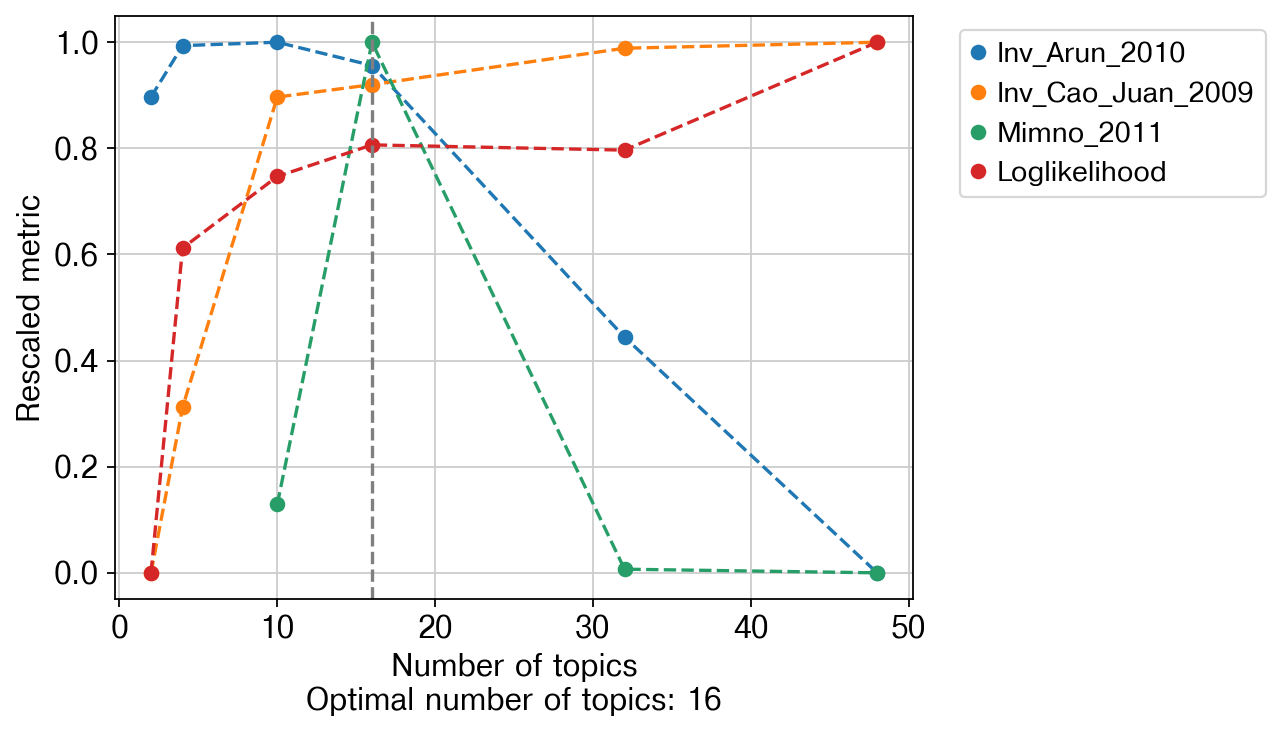

In [9]:
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)


In [57]:
cistopic_obj.add_cell_data(atac_metadata, split_pattern='-')
cistopic_obj.add_LDA_model(model)

pickle.dump(cistopic_obj, open(os.path.join(state_dir, 'cistopic_obj.pkl'), 'wb'))

# Visualization of topic modelling

In [29]:
cistopic_obj = pickle.load(open(os.path.join(state_dir, 'cistopic_obj.pkl'), 'rb'))

2022-10-26 14:42:29,001 cisTopic     INFO     Running UMAP


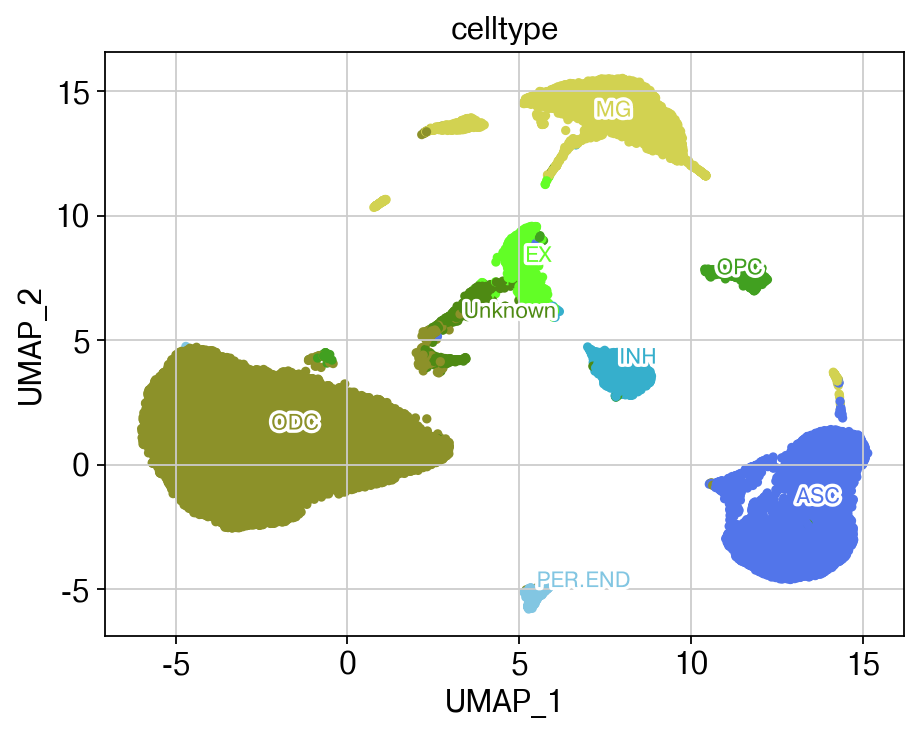

In [30]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

Here we do the same plot using the UMAP coordinates in the metadata.

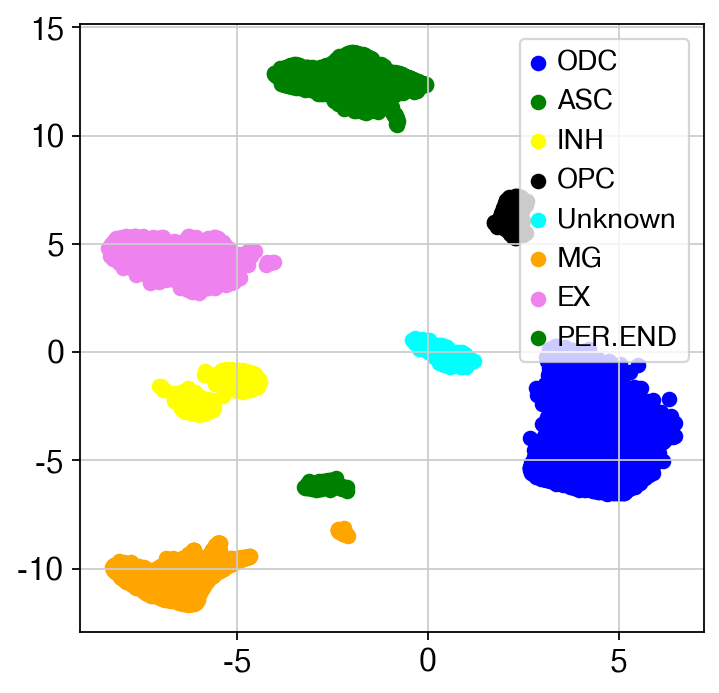

In [31]:
colors = np.random.rand(8)
cmap = {'ODC': 'blue', 
        'ASC': 'green',
        'INH': 'yellow',
        'OPC': 'black',
        'Unknown': 'cyan',
        'MG': 'orange',
        'EX': 'violet',
        'PER.END': 'green'}

na_mask = cistopic_obj.cell_data['celltype'].isna() == False

for celltype in cmap.keys():
    cmask = (cistopic_obj.cell_data['celltype'] == celltype) & na_mask
    mpl.pyplot.scatter(cistopic_obj.cell_data[cmask]['UMAP_1'].values, 
                    cistopic_obj.cell_data[cmask]['UMAP_2'].values,
                    label=celltype,
                    color=cmap[celltype])
mpl.pyplot.legend()

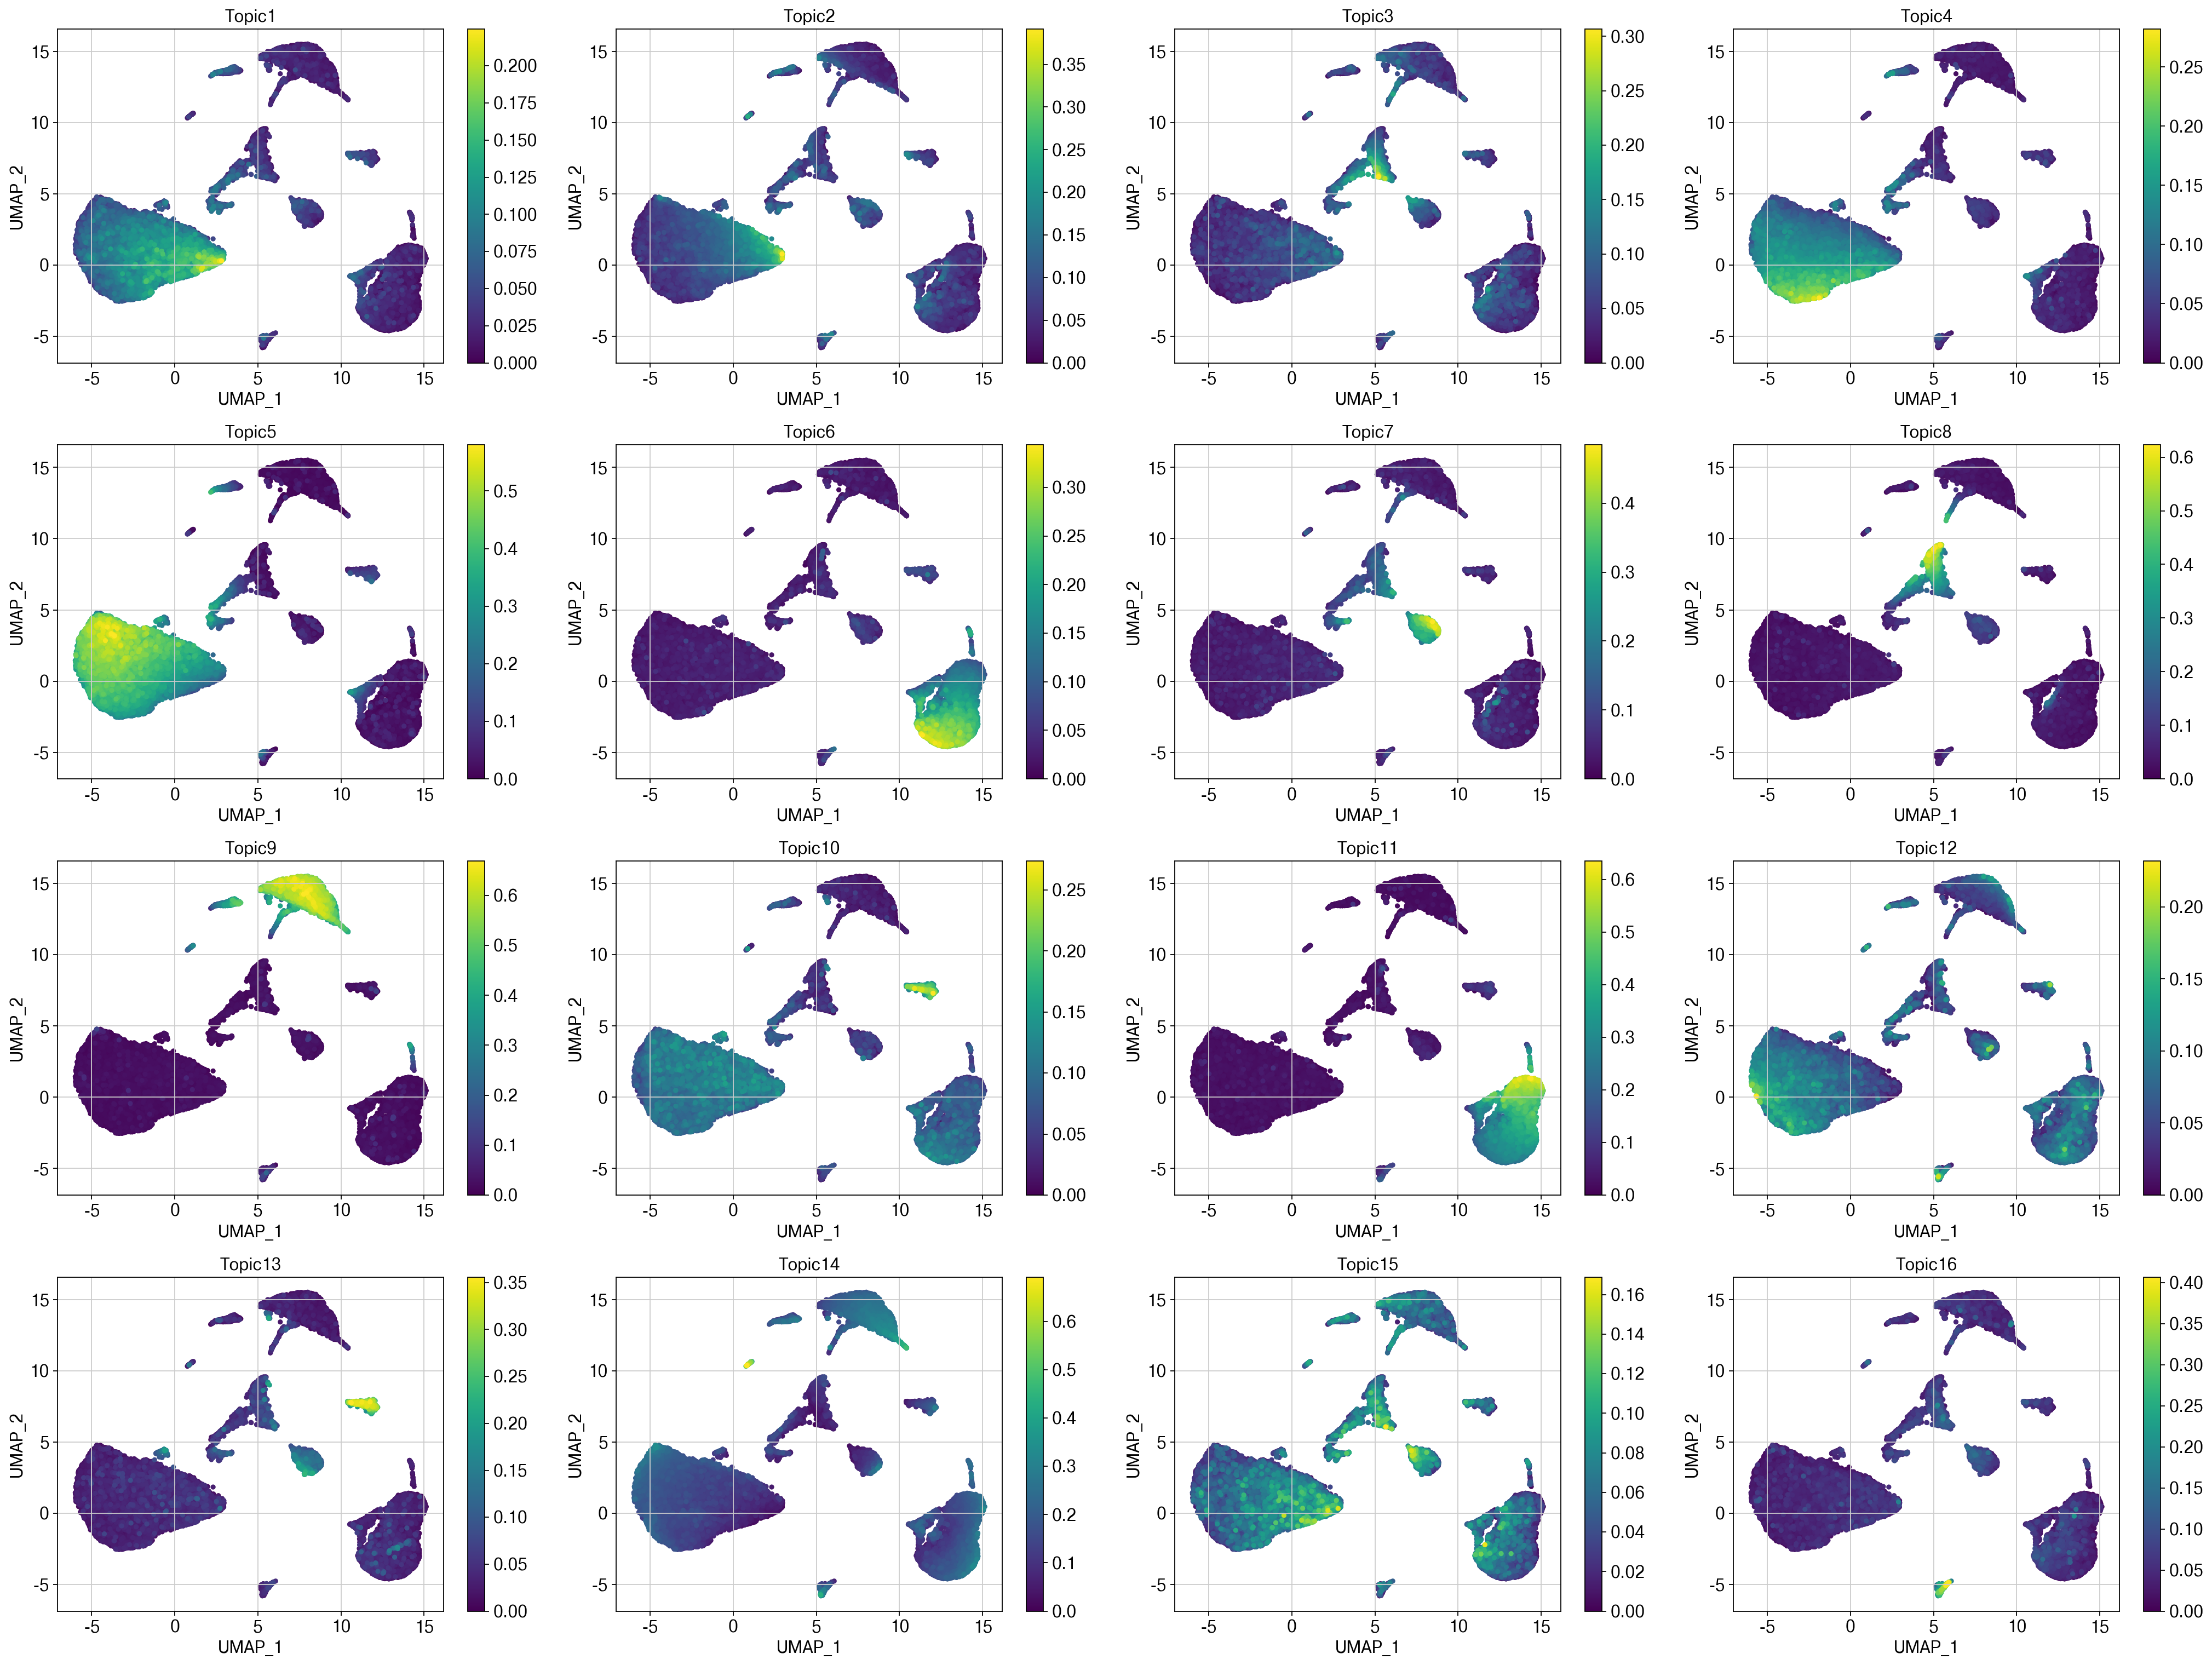

In [32]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)
